In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Activation
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Using TensorFlow backend.


In [2]:
# TBD different random seeds
np.random.seed(7)

### On statefulness

Making a RNN stateful means that the states for the samples of each batch will be reused as initial states for the samples in the next batch.

When using stateful RNNs, it is therefore assumed that:

- all batches have the same number of samples
- if X1 and X2 are successive batches of samples, then X2[i] is the follow-up sequence to X1[i], for every i.

Notes that the methods predict, fit, train_on_batch, predict_classes, etc. will all update the states of the stateful layers in a model. This allows you to do not only stateful training, but also stateful prediction.




In [3]:
# whether to use LSTM or MLP
use_LSTM = True

# number of features used in the regression (for MLP)
mlp_num_features = 5
#

# predict several timesteps at once
lstm_predict_sequences = False
lstm_num_predictions = 5

# lstm_num_timesteps
lstm_num_timesteps = 5
# lstm_num_features
lstm_num_features = 1
# stateful?
lstm_stateful = False
# use two lstm layers?
lstm_stack_layers = False

# window_size
window_size = lstm_num_timesteps if use_LSTM else mlp_num_features

batch_size = 1
num_epochs = 20
# dimensionality of the output space
num_neurons = 4

# scale the dataset to values between scale_min and scale_max
scale = False
scale_min = -1
scale_max = 1
#scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
scaler = StandardScaler()

# number of consecutive (dependent) predictions
prediction_window = 5 


In [4]:
testname = 'seasonal'
properties = 'lstm_' + str(use_LSTM) + '_stateful_' + str(lstm_stateful) + '_window_' + str(window_size) + '_predict_sequences_' + str(lstm_predict_sequences) + '_epochs_' + str(num_epochs) + '_2layers_' + str(lstm_stack_layers) + '_scale_' + str(scale)
model_name = testname + '_' + properties + '.h5'
fig_name = testname + '_' + properties + '.png'
fig_name_multiple = testname + '_' + properties + '_multiplepreds_' + str(prediction_window) + '.png'


model_exists = False

In [5]:
# various test datasets
ts_train_lineartrend = np.arange(1,101, dtype='float64')
ts_test_lineartrend_outofrange = np.arange(101,121, dtype='float64')
ts_test_lineartrend_withinrange = np.arange(21,41, dtype='float64')

ts_train_seasonal = np.tile(np.arange(1,8, dtype='float64'),12)
ts_test_seasonal = np.tile(np.arange(1,8, dtype='float64'),3)

In [6]:
ts_train = ts_train_seasonal
ts_test = ts_test_seasonal


In [7]:
ts_all = np.append(ts_train, ts_test)
len_overall = len(ts_all)

In [8]:
ts_train = np.expand_dims(ts_train, axis = 1)
ts_test = np.expand_dims(ts_test, axis = 1)
ts_all = np.expand_dims(ts_all, axis = 1)


In [9]:
ts_train.shape, ts_test.shape

((84, 1), (21, 1))

In [10]:
ts_train[:10]

array([[ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 1.],
       [ 2.],
       [ 3.]])

In [11]:
ts_test[:10]

array([[ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 1.],
       [ 2.],
       [ 3.]])

In [12]:
if scale:
    ts_train = scaler.fit_transform(ts_train)
    ts_test = scaler.transform(ts_test)

In [13]:
ts_train[:10]

array([[ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 1.],
       [ 2.],
       [ 3.]])

In [14]:
ts_test[:10]

array([[ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 1.],
       [ 2.],
       [ 3.]])

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        a = dataset[i:(i + window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
def create_dataset_multiple_y(dataset, window_size):
    dataX, dataY = [], []
    for i in range(len(dataset) - 2 * window_size):
        a = dataset[i:(i + window_size), 0]
        #print(a)
        dataX.append(a)
        b = dataset[(i + window_size):(i + 2* window_size), 0]
        #print(b)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [17]:
if use_LSTM:
    if lstm_predict_sequences:
        X_train, y_train = create_dataset_multiple_y(ts_train, lstm_num_timesteps)
        X_test, y_test = create_dataset_multiple_y(ts_test, lstm_num_timesteps)
    else:    
        X_train, y_train = create_dataset(ts_train, lstm_num_timesteps)
        X_test, y_test = create_dataset(ts_test, lstm_num_timesteps)
else:
    X_train, y_train = create_dataset(ts_train, mlp_num_features)
    X_test, y_test = create_dataset(ts_test, mlp_num_features)
    
# the train and test matrices end up shorter than the respective timeseries by window_size + 1!
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((79, 5), (79,), (16, 5), (16,))

In [18]:
X_train[:5,:]

array([[ 1.,  2.,  3.,  4.,  5.],
       [ 2.,  3.,  4.,  5.,  6.],
       [ 3.,  4.,  5.,  6.,  7.],
       [ 4.,  5.,  6.,  7.,  1.],
       [ 5.,  6.,  7.,  1.,  2.]])

In [19]:
y_train[:5]

array([ 6.,  7.,  1.,  2.,  3.])

In [20]:
X_test[:5,:]

array([[ 1.,  2.,  3.,  4.,  5.],
       [ 2.,  3.,  4.,  5.,  6.],
       [ 3.,  4.,  5.,  6.,  7.],
       [ 4.,  5.,  6.,  7.,  1.],
       [ 5.,  6.,  7.,  1.,  2.]])

In [21]:
y_test[:5]

array([ 6.,  7.,  1.,  2.,  3.])

In [22]:
if use_LSTM:
    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], lstm_num_timesteps, lstm_num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], lstm_num_timesteps, lstm_num_features))
    
    if lstm_predict_sequences:
        y_train = np.reshape(y_train, (y_train.shape[0], lstm_num_predictions, lstm_num_features))
        y_test = np.reshape(y_test, (y_test.shape[0], lstm_num_predictions, lstm_num_features))

In [23]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((79, 5, 1), (79,), (16, 5, 1), (16,))

In [57]:
if not model_exists:
    
    model = Sequential()

    # LSTM input shape
    # (samples, time steps, features)
    # LSTM output shape
    # if return_sequences: 3D tensor with shape (batch_size, timesteps, units).
    # else, 2D tensor with shape (batch_size, units).

    if use_LSTM:

        print('LSTM')
        # the last state for each sample at index i in a batch will be used as initial state
        # for the sample of index i in the following batch
        if lstm_stateful:
            print('stateful')
            #
            if lstm_stack_layers:
                print('stack_layers')
                model.add(LSTM(num_neurons,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                           stateful = True,
                           return_sequences = True))
                print(model.output_shape)
                model.add(LSTM(num_neurons,
                           stateful = True))
                print(model.output_shape)
                model.add(Dense(1))
                print(model.output_shape)
                model.compile(loss='mean_squared_error', optimizer='adam')

            # 
            elif lstm_predict_sequences:
                print('predict_sequences')
                model.add(LSTM(num_neurons,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                           stateful = True,
                           return_sequences = True))
                print(model.output_shape)
                model.add(TimeDistributed(Dense(1)))
                print(model.output_shape)
                model.add(Activation("linear"))  
                model.compile(loss='mean_squared_error', optimizer='adam')

            #    
            else:
                print('predict single')
                model.add(LSTM(num_neurons,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
                           stateful = True))
                print(model.output_shape)
                model.add(Dense(1))
                print(model.output_shape)
                model.compile(loss='mean_squared_error', optimizer='adam')



        # stateful == False    
        else: 
            print('stateless')

            if lstm_stack_layers:
                print('stack layers')
                # input_dim: dimensionality of the input (alternatively, input_shape)
                # required when using this layer as the first layer in a model
                model.add(LSTM(num_neurons, input_dim = lstm_num_features, return_sequences = True))
                print(model.output_shape)
                model.add(LSTM(num_neurons))
                print(model.output_shape)
                model.add(Dense(1))
                print(model.output_shape)
                model.compile(loss='mean_squared_error', optimizer='adam')
            # 
            # 
            elif lstm_predict_sequences:
                print('predict_sequences')
                model.add(LSTM(num_neurons,
                          #  input_dim = lstm_num_features,
                           batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
                           return_sequences = True))
                print(model.output_shape) 
                model.add(TimeDistributed(Dense(1)))
                print(model.output_shape) 
                model.compile(loss='mean_squared_error', optimizer='adam')

            else:
                print('predict single')
                model.add(LSTM(num_neurons, 
                               input_shape=(X_train.shape[1], X_train.shape[2])
                               #input_dim = lstm_num_features
                              )
                              )
                print(model.output_shape) 
                model.add(Dense(1))
                print(model.output_shape) 
                model.compile(loss='mean_squared_error', optimizer='adam')



    # feedforward
    else:
        print('MLP')

        model.add(Dense(num_neurons, input_dim = mlp_num_features, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

else:
    print('loading from file: ' + model_name)
    model = load_model(model_name)

LSTM
stateless
predict single
(None, 4)
(None, 1)


In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [59]:
if not model_exists:
    if use_LSTM & lstm_stateful:

        for i in range(num_epochs):
                print('epoch: ' + str(i))
                # shuffle must be False!
                model.fit(X_train, y_train, epochs = 1, batch_size = batch_size, shuffle = False)
                model.reset_states()

    else: 
        model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)


Epoch 1/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 2/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 3/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 4/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 5/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 6/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 7/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 8/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 9/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 10/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 11/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 12/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 13/20
79/79 [==============================] - 0s - loss: 13.4430     
Epoch 14

In [60]:
if not model_exists:
    model.save(model_name)

In [61]:
test_loss = np.nan
if lstm_stateful:
    test_loss = model.evaluate(X_test, y_test, batch_size = batch_size)
else:
    test_loss = model.evaluate(X_test, y_test, batch_size = batch_size)
test_loss

 1/16 [>.............................] - ETA: 1s

15.1875

In [64]:
if lstm_stateful:
    model.reset_states()
    pred_train = model.predict(X_train, batch_size = batch_size)
    model.reset_states()
    pred_test = model.predict(X_test, batch_size = batch_size)
else:
    pred_train = model.predict(X_train, batch_size = batch_size)
    pred_test = model.predict(X_test, batch_size = batch_size)

16/16 [==============================] - 0sA: 0s


In [30]:
for i in X_test:
    if use_LSTM:
        if lstm_stateful:
            model.reset_states()
        #print(i)
        r = i.reshape(1, len(i), 1)
        #print(i.shape), print(r.shape)
        print(model.predict(r))
    else:
        r = i.reshape(1, len(i))
        #print(i.shape), print(r.shape)
        print(model.predict(r))

[[ 4.95589256]]
[[ 4.84072161]]
[[ 3.29214668]]
[[ 2.22021914]]
[[ 2.82796621]]
[[ 3.94279909]]
[[ 4.86829185]]
[[ 4.95589256]]
[[ 4.84072161]]
[[ 3.29214668]]
[[ 2.22021914]]
[[ 2.82796621]]
[[ 3.94279909]]
[[ 4.86829185]]
[[ 4.95589256]]
[[ 4.84072161]]


In [31]:
pred_test

array([[ 4.95589256],
       [ 4.84072161],
       [ 3.29214668],
       [ 2.22021914],
       [ 2.82796621],
       [ 3.94279909],
       [ 4.86829185],
       [ 4.95589256],
       [ 4.84072161],
       [ 3.29214668],
       [ 2.22021914],
       [ 2.82796621],
       [ 3.94279909],
       [ 4.86829185],
       [ 4.95589256],
       [ 4.84072161]], dtype=float32)

In [32]:
def calc_dependent_predictions(model, data, prediction_window):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_window)):
        print('Calculating predictions starting from: {}'.format(i))
        curr_frame = data[i*prediction_window]
        predicted = []
        for j in range(prediction_window):
            #print('Calculating single prediction: {}'.format(j))
            #print(curr_frame)
            pred = model.predict(curr_frame[np.newaxis,:,:])[0,0]
            #pred = model.predict(curr_frame.reshape(1, len(curr_frame), 1)) # same
            #print(pred)
            predicted.append(pred)
            curr_frame = curr_frame[1:] 
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [33]:
if use_LSTM and not lstm_predict_sequences:
    prediction_seqs_train = calc_dependent_predictions(model, X_train, prediction_window)
    prediction_seqs_test = calc_dependent_predictions(model, X_test, prediction_window)

Calculating predictions starting from: 0
Calculating predictions starting from: 1
Calculating predictions starting from: 2
Calculating predictions starting from: 3
Calculating predictions starting from: 4
Calculating predictions starting from: 5
Calculating predictions starting from: 6
Calculating predictions starting from: 7
Calculating predictions starting from: 8
Calculating predictions starting from: 9
Calculating predictions starting from: 10
Calculating predictions starting from: 11
Calculating predictions starting from: 12
Calculating predictions starting from: 13
Calculating predictions starting from: 14
Calculating predictions starting from: 0
Calculating predictions starting from: 1
Calculating predictions starting from: 2


In [34]:
if use_LSTM and not lstm_predict_sequences:
    print(prediction_seqs_train)

[[4.9558926, 4.8687878, 3.9897041, 3.3524127, 3.3831468], [3.9427991, 4.8684464, 4.9553237, 4.8793426, 4.0957994], [2.2202191, 2.8834538, 3.8919611, 4.8657365, 4.9552522], [4.8407216, 3.6487203, 3.1734366, 3.1832919, 3.9185872], [4.8682919, 4.9549203, 4.8751769, 4.056973, 3.3838587], [2.8279662, 3.9077125, 4.8687224, 4.9567962, 4.8921738], [3.2921467, 2.931221, 2.9160166, 3.4024086, 4.7014613], [4.9558926, 4.8687878, 3.9897041, 3.3524127, 3.3831468], [3.9427991, 4.8684464, 4.9553237, 4.8793426, 4.0957994], [2.2202191, 2.8834538, 3.8919611, 4.8657365, 4.9552522], [4.8407216, 3.6487203, 3.1734366, 3.1832919, 3.9185872], [4.8682919, 4.9549203, 4.8751769, 4.056973, 3.3838587], [2.8279662, 3.9077125, 4.8687224, 4.9567962, 4.8921738], [3.2921467, 2.931221, 2.9160166, 3.4024086, 4.7014613], [4.9558926, 4.8687878, 3.9897041, 3.3524127, 3.3831468]]


In [35]:
if use_LSTM and not lstm_predict_sequences:
    print(prediction_seqs_test)

[[4.9558926, 4.8687878, 3.9897041, 3.3524127, 3.3831468], [3.9427991, 4.8684464, 4.9553237, 4.8793426, 4.0957994], [2.2202191, 2.8834538, 3.8919611, 4.8657365, 4.9552522]]


In [36]:
y_train[:10]

array([ 6.,  7.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  1.])

In [37]:
pred_train[:10,0]

array([ 4.95589256,  4.84072161,  3.29214668,  2.22021914,  2.82796621,
        3.94279909,  4.86829185,  4.95589256,  4.84072161,  3.29214668], dtype=float32)

In [38]:
y_test[:10]

array([ 6.,  7.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  1.])

In [39]:
pred_test[:10,0]

array([ 4.95589256,  4.84072161,  3.29214668,  2.22021914,  2.82796621,
        3.94279909,  4.86829185,  4.95589256,  4.84072161,  3.29214668], dtype=float32)

In [40]:
if scale:
    pred_train = scaler.inverse_transform(pred_train)
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    pred_test = scaler.inverse_transform(pred_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))


In [41]:
y_train[:10],pred_train[:10,0]

(array([ 6.,  7.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  1.]),
 array([ 4.95589256,  4.84072161,  3.29214668,  2.22021914,  2.82796621,
         3.94279909,  4.86829185,  4.95589256,  4.84072161,  3.29214668], dtype=float32))

In [42]:
y_test[:],pred_test[:,0]

(array([ 6.,  7.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  1.,  2.,  3.,  4.,
         5.,  6.,  7.]),
 array([ 4.95589256,  4.84072161,  3.29214668,  2.22021914,  2.82796621,
         3.94279909,  4.86829185,  4.95589256,  4.84072161,  3.29214668,
         2.22021914,  2.82796621,  3.94279909,  4.86829185,  4.95589256,
         4.84072161], dtype=float32))

In [43]:
# calculate root mean squared error
rsme_train = math.sqrt(mean_squared_error(y_train, pred_train[:,0]))
print('Train Score: %.2f RMSE' % (rsme_train))
rsme_test = math.sqrt(mean_squared_error(y_test, pred_test[:,0]))
print('Test Score: %.2f RMSE' % (rsme_test))

Train Score: 1.27 RMSE
Test Score: 1.32 RMSE


In [44]:
print(len(ts_train), len(pred_train), len(y_train))
len(ts_test), len(pred_test), len(y_test) 

84 79 79


(21, 16, 16)

In [45]:
# shift train predictions for plotting
pred_train_shifted = np.empty_like(ts_all)
print(pred_train_shifted.size)
pred_train_shifted[:, :] = np.nan
# train predictions start at position window_size + 1 (or window_size, if counting from 0)
pred_train_shifted[window_size : len(pred_train) + window_size, :] = pred_train
pred_train_shifted[:13]

105


array([[        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [ 4.95589256],
       [ 4.84072161],
       [ 3.29214668],
       [ 2.22021914],
       [ 2.82796621],
       [ 3.94279909],
       [ 4.86829185],
       [ 4.95589256]])

In [46]:
# shift test predictions for plotting
window_size = lstm_num_timesteps if use_LSTM else mlp_num_features
pred_test_shifted = np.empty_like(ts_all)
pred_test_shifted[:, :] = np.nan
pred_test_shifted[len(pred_train) + (window_size * 2) : len_overall + 1, :] = pred_test
pred_test_shifted[-13:]

array([[ 2.22021914],
       [ 2.82796621],
       [ 3.94279909],
       [ 4.86829185],
       [ 4.95589256],
       [ 4.84072161],
       [ 3.29214668],
       [ 2.22021914],
       [ 2.82796621],
       [ 3.94279909],
       [ 4.86829185],
       [ 4.95589256],
       [ 4.84072161]])

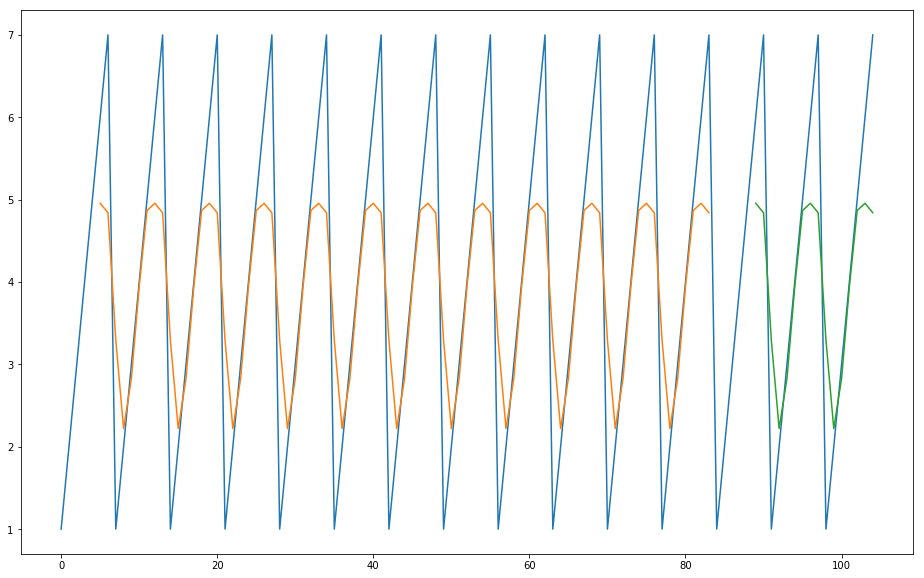

In [47]:
plt.plot(ts_all)
plt.plot(pred_train_shifted)
plt.plot(pred_test_shifted)
#plt.savefig(fig_name)
plt.show()

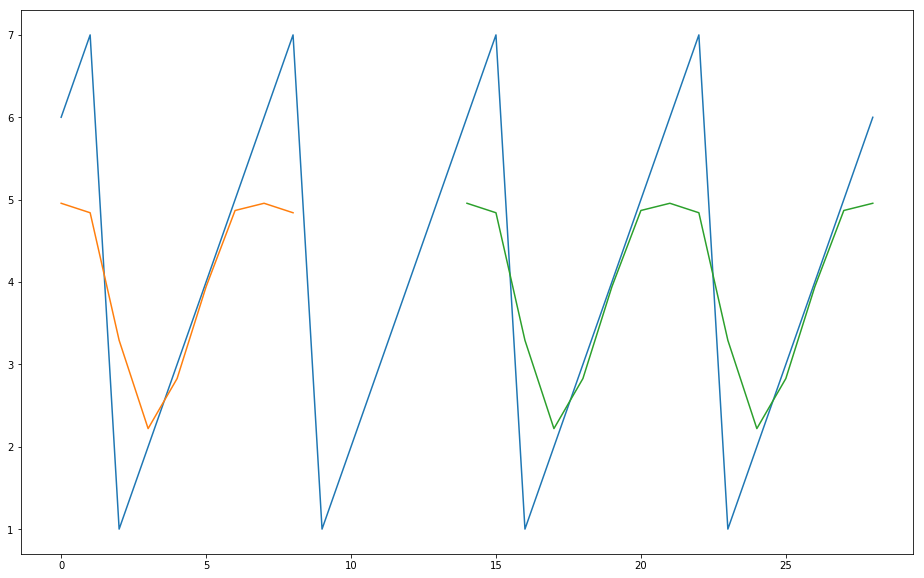

In [48]:
plot_start = -30
plot_end = -1
plt.plot(ts_all[plot_start:plot_end])
plt.plot(pred_train_shifted[plot_start:plot_end])
plt.plot(pred_test_shifted[plot_start:plot_end])
plt.show()


In [49]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

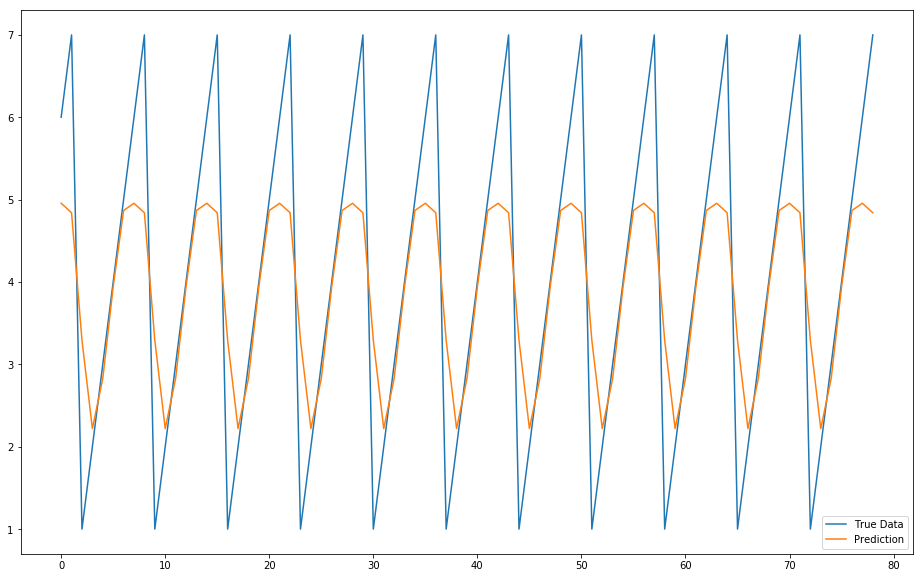

In [50]:
plot_results(pred_train, y_train)

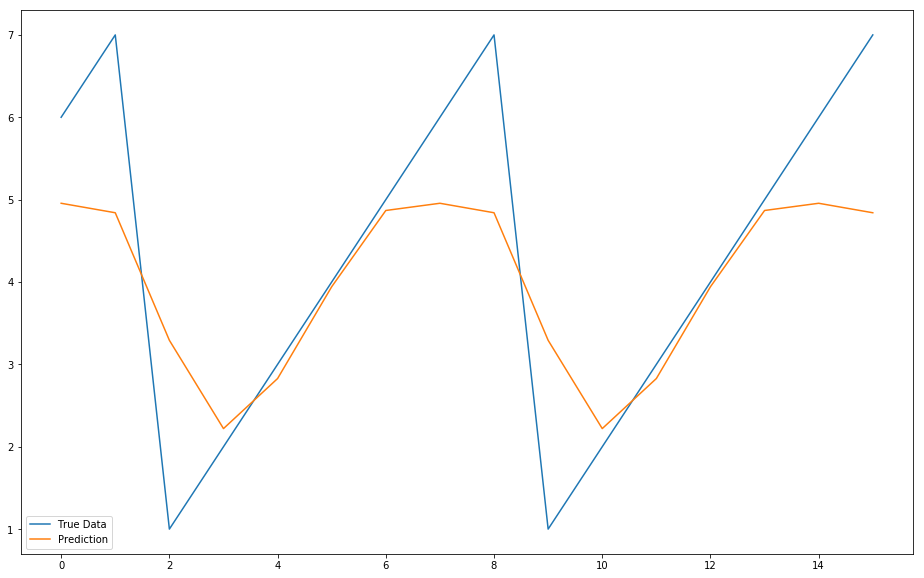

In [51]:
plot_results(pred_test, y_test)

In [52]:
def plot_results_multiple(predicted_data, true_data, prediction_window):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_window)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.savefig(fig_name)
    plt.show()

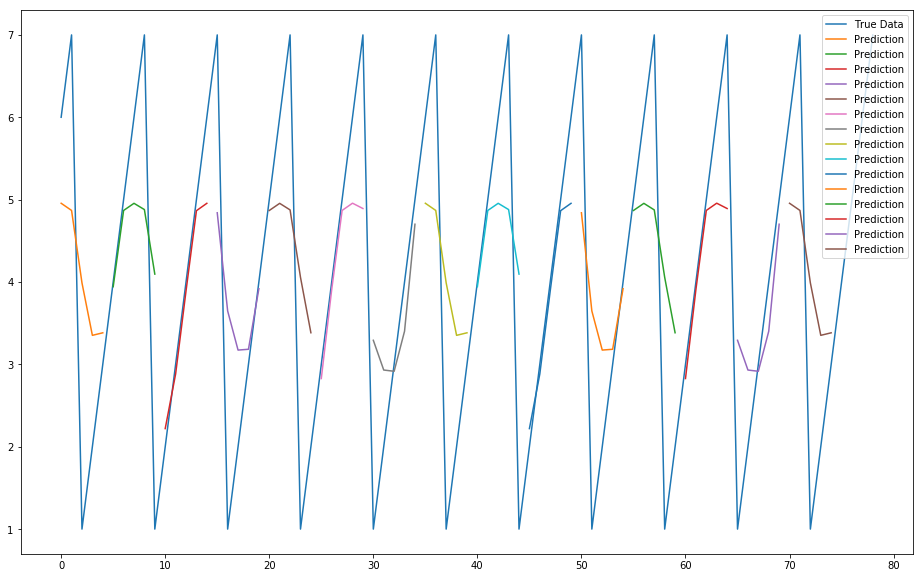

In [53]:
if use_LSTM:
    plot_results_multiple(prediction_seqs_train, y_train, prediction_window)

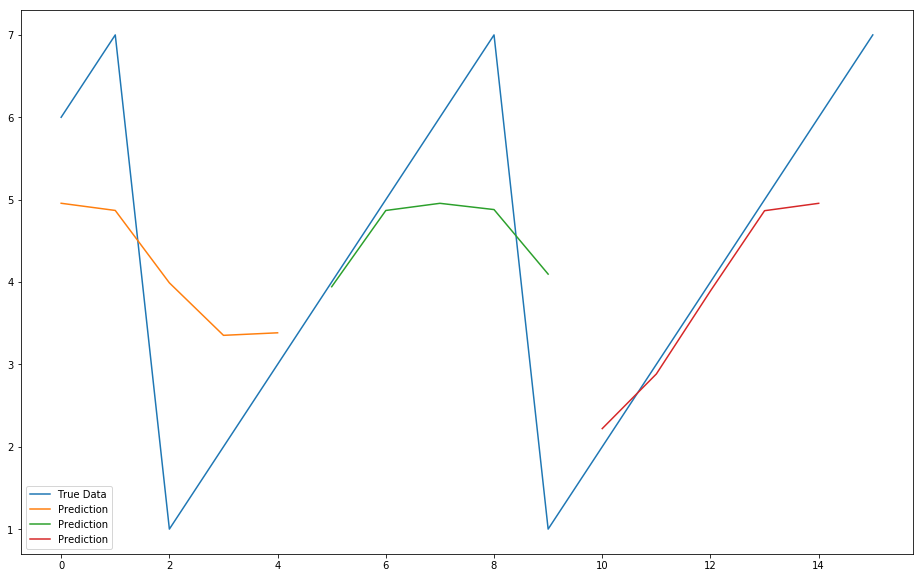

In [54]:
if use_LSTM:
    plot_results_multiple(prediction_seqs_test, y_test, prediction_window)